<div class="alert alert-block alert-success">
<h3>Entrenamiento / Evaluación</h3>
</div>

In [71]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 💪 Training

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.feature_selection import SelectKBest

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [73]:
proc_data_path='../data/processed/road_traffic_accidents_dataset_proc.csv'
train_data = pd.read_csv(proc_data_path)


**Dividimos el dataset en train y test**

In [74]:
x = train_data.drop('accident_severity', axis=1)
y = train_data['accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


**Guardamos los datos de train y test en archivos CSV**

In [75]:
print('Train x shape:', xtrain.shape)
print('Train y shape:', ytrain.shape)
print('Test x shape:', xtest.shape)
print('Test y shape:', ytest.shape)

xtrain.to_csv('../data/train/xtrain.csv', index=False)
ytrain.to_csv('../data/train/ytrain.csv', index=False)
xtest.to_csv('../data/test/xtest.csv', index=False)
ytest.to_csv('../data/test/ytest.csv', index=False)


Train x shape: (9852, 229)
Train y shape: (9852,)
Test x shape: (2464, 229)
Test y shape: (2464,)


**Generamos los modelos a emplear**

In [76]:
models={"LogisticRegression":LogisticRegression(max_iter=1000),
        "DecisionTreeClassifier":DecisionTreeClassifier(random_state=42),
        "KNeighborsClassifier":KNeighborsClassifier(n_neighbors=5),
        "RandomForestClassifier":RandomForestClassifier(n_estimators=200, random_state=42)
        }


**Calculamos la accuracy para cada modelo**

In [77]:
def modelAccuracy(models,x,y):
    acc_result={}

    for name,model in models.items():
        #pipeline: 1.StandardScaler -> 2.Model
        model_pipeline = Pipeline([('StandardScaler',StandardScaler()),('model',model)])

        #training/testing on model pipeline
        model_fit = model_pipeline.fit(x,y)
        ypred = model_fit.predict(xtest)
        acc = accuracy_score(ytest,ypred)

        print("The Accuracy for {:<25} is: {:>16.13f}".format(name, acc))
        acc_result[name] = acc

    return acc_result


In [78]:
acc_result = modelAccuracy(models,xtrain,ytrain)


The Accuracy for LogisticRegression        is:  0.8368506493506
The Accuracy for DecisionTreeClassifier    is:  0.7751623376623
The Accuracy for KNeighborsClassifier      is:  0.8364448051948
The Accuracy for RandomForestClassifier    is:  0.8429383116883


**Seleccionamos el modelo con mejor accuracy**

In [79]:
def bestModel(result):
    high = 0
    for name,acc in result.items():
        if acc > high:
            high = acc
            model_name = name
    print("Best Model is ",model_name," with accuaracy =>",high)

In [80]:
bestModel(acc_result)

Best Model is  RandomForestClassifier  with accuaracy => 0.8429383116883117


**Identificamos los hiperparámetros óptimos, aplicando cross_validation**

In [83]:
def bestParams(model,param,xtrain,ytrain):

    cross_val = KFold(n_splits=5, shuffle=True, random_state=42)
    results_cross_val = cross_val_score(model, xtrain, ytrain, cv=cross_val)

    grid_cv = GridSearchCV(estimator=model, param_grid=param, cv=cross_val, scoring='accuracy', n_jobs=-1, verbose=1)

    res = grid_cv.fit(xtrain,ytrain)
    
    print(results_cross_val)
    print("Best Parameters are ",res.best_params_)
    print("Best Accuracy is ",res.best_score_)


In [84]:
model = RandomForestClassifier()

params = {"n_estimators" : [25,50,100,200],
         "max_features" : [3,4,5,6],
         "max_depth": [3,4,5,6]
         }
         
bestParams(model,params,xtrain,ytrain)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[0.84525622 0.84525622 0.85431472 0.85583756 0.84873096]
Best Parameters are  {'max_depth': 3, 'max_features': 3, 'n_estimators': 25}
Best Accuracy is  0.847646148338729


**Generemos el modelo aplicando los hiperparámetros obtenidos**


In [85]:
model = RandomForestClassifier(max_depth=5, max_features=5, n_estimators=200, class_weight='balanced')

model.fit(xtrain,ytrain)


RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=5,
                       n_estimators=200)

**Exportamos el modelo generado**

In [86]:
import pickle
pickle.dump(model,open("../models/road_traffic_accidents_model.pkl","wb"))


#### 📯 Predict

In [87]:
ypred = model.predict(xtest)

print("Accuracy of the model is ",accuracy_score(ytest,ypred))


Accuracy of the model is  0.6582792207792207


**Generamos el Classification Report**

In [88]:
print("Accuracy:", accuracy_score(ytest, ypred))

print("\nClassification Report:")
print(classification_report(ytest, ypred, zero_division=0))


Accuracy: 0.6582792207792207

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.51      0.15        37
           1       0.24      0.38      0.29       363
           2       0.88      0.71      0.79      2064

    accuracy                           0.66      2464
   macro avg       0.40      0.53      0.41      2464
weighted avg       0.77      0.66      0.70      2464



**Generamos la Matriz de Confusión**


Confusion Matrix:
[[  19   10    8]
 [  29  137  197]
 [ 172  426 1466]]


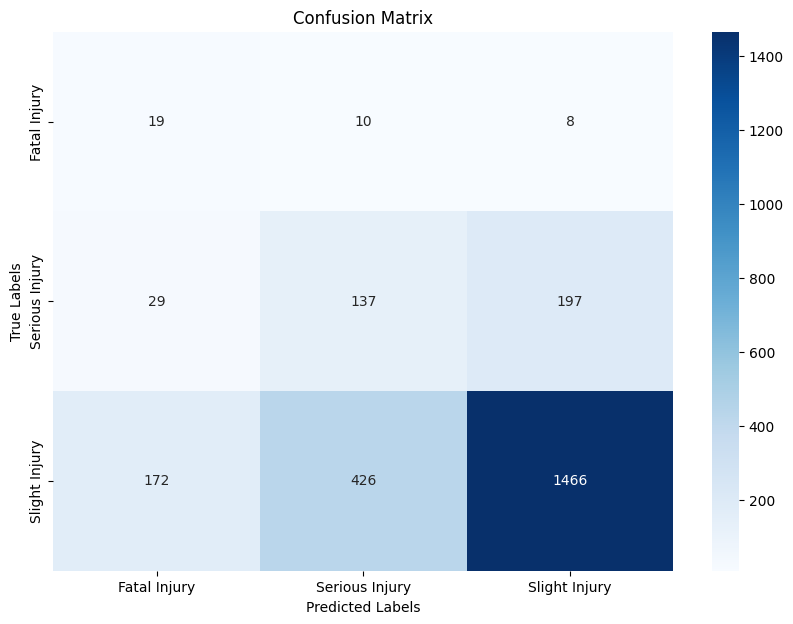

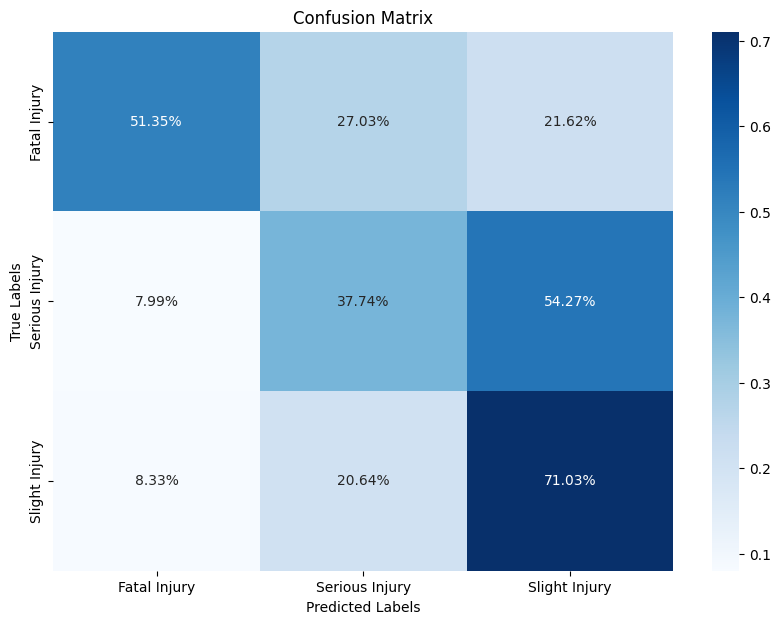

In [89]:

c_matrix = confusion_matrix(ytest, ypred)
print("\nConfusion Matrix:")
print(c_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(ytest, ypred, normalize='true'), annot=True, fmt='.2%', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Visualizamos las features más relevantes**


Feature Importances:
                                    feature  importance
159                  number_of_casualties_4    0.063495
156                  number_of_casualties_1    0.044272
35               age_band_of_driver_unknown    0.025675
150           number_of_vehicles_involved_1    0.024769
21                                  time_21    0.022251
113              types_of_junction_crossing    0.019099
151           number_of_vehicles_involved_2    0.018648
26                     day_of_week_saturday    0.018231
129  light_conditions_darkness - lights lit    0.017115
114           types_of_junction_no junction    0.015788


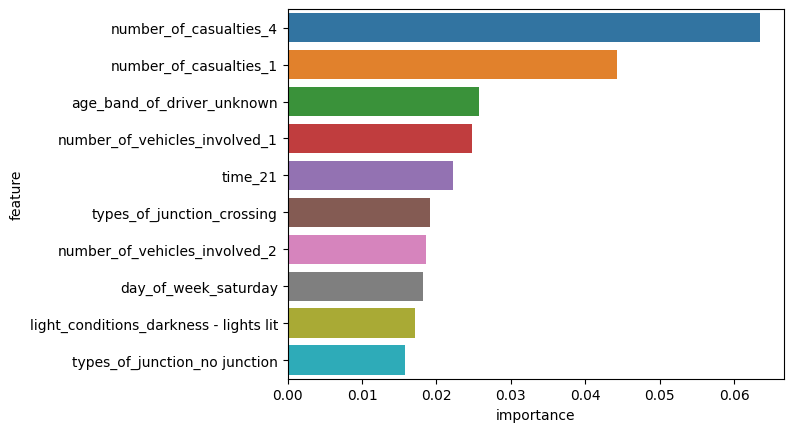

In [90]:
feature_importances = model.feature_importances_
feature_names = x.columns
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances_df.head(10))

sns.barplot(x='importance', y='feature', data=feature_importances_df.head(10), hue='feature');
